In [4]:
# %%
import os, sys, glob
from nilearn import image
from nilearn import plotting
import numpy as np
import pandas as pd

from scipy import io
import matplotlib.pyplot as plt
import matplotlib.cm
cmap = matplotlib.cm.get_cmap('Reds')

%matplotlib inline

In [161]:
sys.path.append('/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages')
import rsatoolbox
import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr

### getting started


In [27]:
brainrdm = io.matlab.loadmat('/Users/h/Downloads/92_behavRDMs.mat')
brainrdm

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu May 23 12:24:58 2013',
 '__version__': '1.0',
 '__globals__': [],
 'rdms_behav_92': array([[(array([[0.        , 0.02537531, 0.00282162, ..., 0.02316077, 0.02018694,
                 0.01637597],
                [0.02537531, 0.        , 0.02671253, ..., 0.01242292, 0.01703296,
                 0.01018642],
                [0.00282162, 0.02671253, 0.        , ..., 0.02337334, 0.01987843,
                 0.01727166],
                ...,
                [0.02316077, 0.01242292, 0.02337334, ..., 0.        , 0.01015248,
                 0.00710975],
                [0.02018694, 0.01703296, 0.01987843, ..., 0.01015248, 0.        ,
                 0.00775922],
                [0.01637597, 0.01018642, 0.01727166, ..., 0.00710975, 0.00775922,
                 0.        ]]), array(['simJudge | subject1'], dtype='<U19'), array([[0.5, 0.5, 0.5]])),
         (array([[0.        , 0.00550719, 0.00128155, ..., 0.01403361, 0.02

Text(0.5, 1.0, 'Measurements')

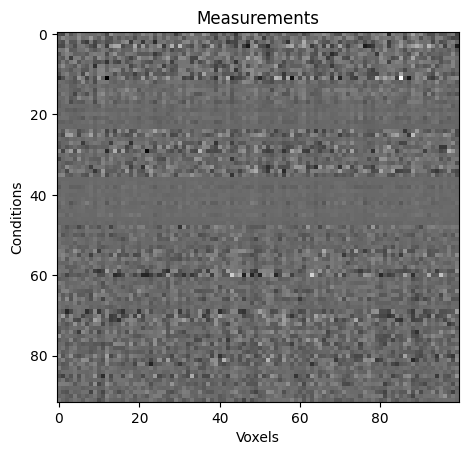

In [9]:
# import the measurements for the dataset
measurements = io.matlab.loadmat('/Users/h/Downloads/simTruePatterns.mat')
measurements = measurements['simTruePatterns']
nCond = measurements.shape[0]
nVox = measurements.shape[1]

# plot the imported data
plt.imshow(measurements,cmap='gray')
plt.xlabel('Voxels')
plt.ylabel('Conditions')
plt.title('Measurements')

In [420]:
def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))


def load_outcome(data_dir, sub, ses):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_outcome = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist:
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_04outcome = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns = ['trial_order', 'run_order'],
                            values=['event04_actual_angle']) #, aggfunc='first')
        seswise_04outcome.columns  = [ col[0]+'_'+str(col[1]) for col in seswise_04outcome.columns.values]
        seswise_04outcome = seswise_04outcome.reset_index()
        seswise_04outcome["condition"] = task + '_' + seswise_04outcome['param_cue_type'].astype(str) + '_' + seswise_04outcome["param_stimulus_type"]

        # reorder values
        seswise_04outcome['stim_order'] = seswise_04outcome['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        seswise_04outcome['cue_order'] = seswise_04outcome['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        ses_outcome = seswise_04outcome.sort_values(['cue_order','stim_order'])
        seswise_outcome = pd.concat([seswise_outcome, ses_outcome])
    return(seswise_outcome.reset_index(drop = True))



def load_fmri(singletrial_dir, sub, ses, run):
    get_shape = glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
    get_shape_data = image.mean_img(image.concat_imgs(get_shape)).get_fdata().ravel()
    # task_array = np.empty((18,0), int)
    arr = np.empty((0, get_shape_data.shape[0]), int)
    for runtype in ['pain','cognitive', 'vicarious']:
        stim_H_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]
        stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
        stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
        stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
        stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
        stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
        stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()

        runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
        # task_array = np.vstack((task_array, runwise_array))
        # arr = np.append(arr, runwise_array, axis=0)
        
    # np.vstack((arr, runwise_array))
        arr = np.concatenate((arr,runwise_array),axis=0)
    return(arr)

In [311]:
expect_df = load_expect(data_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
            sub = 'sub-0061', ses = 'ses-01')
outcome_df = load_outcome(data_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
            sub = 'sub-0061', ses = 'ses-01')

In [312]:
expect_df

,param_cue_type,param_stimulus_type,event02_expect_angle_0,event02_expect_angle_0,event02_expect_angle_1,event02_expect_angle_1,condition,stim_order,cue_order
0,high_cue,high_stim,123.881265,55.290315,NaN,97.869076,pain_high_cue_high_stim,0,0
1,high_cue,med_stim,NaN,98.292413,NaN,108.434949,pain_high_cue_med_stim,1,0
2,high_cue,low_stim,106.260205,63.845664,104.649904,109.885165,pain_high_cue_low_stim,2,0
3,low_cue,high_stim,11.900590,29.683140,NaN,NaN,pain_low_cue_high_stim,0,1
4,low_cue,med_stim,NaN,13.201087,22.442753,24.919664,pain_low_cue_med_stim,1,1
5,low_cue,low_stim,NaN,15.722580,NaN,27.286363,pain_low_cue_low_stim,2,1
6,high_cue,high_stim,45.164171,35.483980,63.226980,53.130102,vicarious_high_cue_high_stim,0,0
7,high_cue,med_stim,NaN,68.640073,37.191008,58.679882,vicarious_high_cue_med_stim,1,0
8,high_cue,low_stim,67.255888,71.929988,NaN,53.955765,vicarious_high_cue_low_stim,2,0
9,low_cue,high_stim,4.840112,NaN,NaN,17.271743,vicarious_low_cue_high_stim,0,1


In [306]:
np.array(expect_df.filter(regex='event02_'))

array([[123.88126519,  55.29031546,          nan,  97.86907555],
       [         nan,  98.29241291,          nan, 108.43494882],
       [106.26020471,  63.84566422, 104.64990411, 109.88516511],
       [ 11.90058969,  29.68314018,          nan,          nan],
       [         nan,  13.20108718,  22.44275337,  24.91966437],
       [         nan,  15.7225801 ,          nan,  27.28636281],
       [ 45.16417084,  35.4839798 ,  63.22697957,  53.13010235],
       [         nan,  68.64007323,  37.19100754,  58.67988178],
       [ 67.25588789,  71.92998751,          nan,  53.955765  ],
       [  4.84011249,          nan,          nan,  17.27174258],
       [         nan,   7.7335981 ,   8.8520041 ,          nan],
       [  0.        ,  16.32462332,   8.78116273,   9.68878656],
       [116.87813975, 122.85975204,  88.84963694, 113.37952395],
       [ 50.10509045, 114.46339685,  74.84593195, 106.10358374],
       [128.36748538,  93.44738685,  94.41651567,  99.50024132],
       [  5.54977942,   7

## convert behavioral data into RDM

In [22]:
# # calculate mean of expectation / outcome rating
# sessionwise_02expect= runwise_df.groupby(['param_cue_type', 'param_stimulus_type'])['event02_expect_angle'].mean()
# sessionwise_04outcome= runwise_df.groupby(['param_cue_type', 'param_stimulus_type'])['event04_actual_angle'].mean()
# # convert as a pandas dataframe
# # seswise_02expect = pd.DataFrame(sessionwise_02expect).reset_index()
# # seswise_04outcome = pd.DataFrame(sessionwise_04outcome).reset_index()

In [427]:
# now create a  dataset object
sub_list = ['sub-0061', 'sub-0062']
ses_list = ['ses-01', 'ses-03', 'ses-04']
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        des = {'session': ses, 'subj': sub}
        expect_df = pd.DataFrame()
        
        expect_df = load_expect(data_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                sub = sub, ses = ses)
        obs_des = {'pattern': np.array(expect_df.condition)}
        chn_des = {'ratings': np.array(['ratings_' + str(x) for x in np.arange(4)])}
        beh_expect.append(rsd.Dataset(measurements=np.array(expect_df.filter(regex='event02_')),
                                descriptors=des,
                                obs_descriptors=obs_des,
                                channel_descriptors=chn_des))
        
        outcome_df = load_outcome(data_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                sub = sub, ses = ses)
        beh_outcome.append(rsd.Dataset(measurements=np.array(outcome_df.filter(regex='event04_')),
                        descriptors=des,
                        obs_descriptors=obs_des,
                        channel_descriptors=chn_des))
        


# brain RDM


In [ ]:
sub_list = ['sub-0061', 'sub-0062']
ses_list = ['ses-01', 'ses-03', 'ses-04']
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        fmri_df = load_fmri(singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/',
                      sub = sub, ses = ses, run = '*')
        obs_des = {'pattern': np.array(expect_df.condition)}
        fmri_data.append(rsd.Dataset(measurements=fmri_df,
                                descriptors=des,
                                obs_descriptors=obs_des,
                                channel_descriptors={'voxels': np.array(['voxel_' + str(x) for x in np.arange(fmri_df.shape[1])])}))

In [431]:
rdms_expect = rsr.calc_rdm(beh_expect)
rdms_outcome = rsr.calc_rdm(beh_outcome)
rdms_fmri = rsr.calc_rdm(fmri_data)
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(fmri_data, obs_desc='pattern', method='shrinkage_eye')
rdm_fmri_maha_shrink = rsatoolbox.rdm.calc_rdm(fmri_data, descriptor='pattern', method='mahalanobis', noise=noise_prec_shrink)

rsatoolbox.vis.show_rdm(rdms_expect)
rsatoolbox.vis.show_rdm(rdms_outcome)
rsatoolbox.vis.show_rdm(rdms_fmri)
rsatoolbox.vis.show_rdm(rdm_fmri_maha_shrink)

: 

: 

In [2]:
rdms_fmri

NameError: name 'rdms_fmri' is not defined

In [340]:
RDM_euc_expect = rsr.calc_rdm(data_expect, descriptor='pattern')
print(RDM_euc_expect)
dist_vectors_expect = RDM_euc_expect.get_vectors()
dist_vectors_expect
RDM_euc_expect = rsr.RDMs(dist_vectors_expect)

rsatoolbox.rdm.RDMs
6 RDM(s) over 18 conditions

dissimilarity_measure = 
squared euclidean

dissimilarities[0] = 
[[    0.           305.17922858  1194.54548837  9221.17484233
   5833.77460401  7551.65469835            nan   964.31552296
             nan            nan            nan            nan
   4265.98307151            nan            nan            nan
  10543.24069631            nan]
 [  305.17922858     0.          1748.32175398  7996.32579187
   4894.07844294  6626.21307559            nan   394.3906807
             nan            nan            nan            nan
   3351.38126453            nan            nan            nan
   9456.41075896            nan]
 [ 1194.54548837  1748.32175398     0.          5499.33848632
   3081.10872497  4265.65556612            nan  1654.53220703
             nan            nan            nan            nan
   2300.83769721            nan            nan            nan
   6450.52645102            nan]
 [ 9221.17484233  7996.32579187  5499.33848

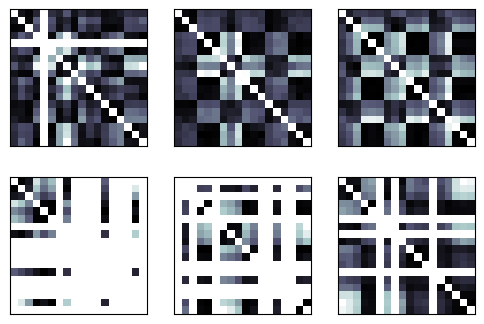

In [341]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(RDM_euc_expect)

In [343]:
rdms.pattern_descriptors

{'pattern': array(['pain_high_cue_high_stim', 'pain_high_cue_med_stim',
        'pain_high_cue_low_stim', 'pain_low_cue_high_stim',
        'pain_low_cue_med_stim', 'pain_low_cue_low_stim',
        'vicarious_high_cue_high_stim', 'vicarious_high_cue_med_stim',
        'vicarious_high_cue_low_stim', 'vicarious_low_cue_high_stim',
        'vicarious_low_cue_med_stim', 'vicarious_low_cue_low_stim',
        'cognitive_high_cue_high_stim', 'cognitive_high_cue_med_stim',
        'cognitive_high_cue_low_stim', 'cognitive_low_cue_high_stim',
        'cognitive_low_cue_med_stim', 'cognitive_low_cue_low_stim'],
       dtype=object),
 'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}

## Many RDMs

In [344]:
rdms = rsr.calc_rdm(data_expect)
print('The number of RDMs is:')
print(rdms.n_rdm)
print()
print('The descriptors for the RDMs are:')
print(rdms.rdm_descriptors)
print()
print('The patterns or conditions are still described at least by their label:')
print(rdms.pattern_descriptors['pattern'])

The number of RDMs is:
6

The descriptors for the RDMs are:
{'session': ['ses-01', 'ses-03', 'ses-04', 'ses-01', 'ses-03', 'ses-04'], 'subj': ['sub-0061', 'sub-0061', 'sub-0061', 'sub-0062', 'sub-0062', 'sub-0062'], 'index': [0, 1, 2, 3, 4, 5]}

The patterns or conditions are still described at least by their label:
['pain_high_cue_high_stim' 'pain_high_cue_med_stim'
 'pain_high_cue_low_stim' 'pain_low_cue_high_stim' 'pain_low_cue_med_stim'
 'pain_low_cue_low_stim' 'vicarious_high_cue_high_stim'
 'vicarious_high_cue_med_stim' 'vicarious_high_cue_low_stim'
 'vicarious_low_cue_high_stim' 'vicarious_low_cue_med_stim'
 'vicarious_low_cue_low_stim' 'cognitive_high_cue_high_stim'
 'cognitive_high_cue_med_stim' 'cognitive_high_cue_low_stim'
 'cognitive_low_cue_high_stim' 'cognitive_low_cue_med_stim'
 'cognitive_low_cue_low_stim']


(<Figure size 600x400 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbebcc2ba60>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbebd7a5760>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbebd7badc0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbebdd3c6d0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbebcc52820>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbebdc396d0>}}))

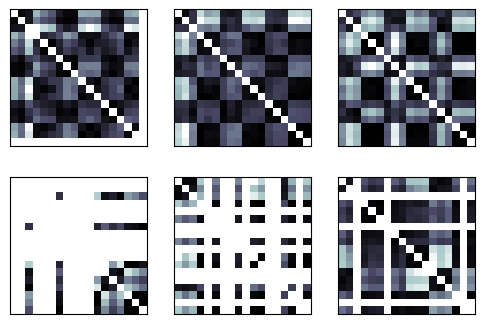

In [347]:
rsatoolbox.vis.show_rdm(rdms)

In [346]:
rdms.subsample_pattern('pattern', ['pain_high_cue_high_stim' 'pain_high_cue_med_stim'
 'pain_high_cue_low_stim' 'pain_low_cue_high_stim' 'pain_low_cue_med_stim'
 'pain_low_cue_low_stim' 'vicarious_high_cue_high_stim'
 'vicarious_high_cue_med_stim' 'vicarious_high_cue_low_stim'
 'vicarious_low_cue_high_stim' 'vicarious_low_cue_med_stim'
 'vicarious_low_cue_low_stim' 'cognitive_high_cue_high_stim'
 'cognitive_high_cue_med_stim' 'cognitive_high_cue_low_stim'
 'cognitive_low_cue_high_stim' 'cognitive_low_cue_med_stim'
 'cognitive_low_cue_low_stim'])

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[]
descriptors = 
{}
rdm_descriptors = 
{'session': ['ses-01', 'ses-03', 'ses-04', 'ses-01', 'ses-03', 'ses-04'], 'subj': ['sub-0061', 'sub-0061', 'sub-0061', 'sub-0062', 'sub-0062', 'sub-0062'], 'index': [0, 1, 2, 3, 4, 5]}
pattern_descriptors = 
{'pattern': [], 'index': []}

In [411]:
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub = 'sub-0061'
ses = 'ses-01'
run = '*' #'run-06'
# runtype = 'pain'
event = 'stimulus'
task_array = []
get_shape = glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
get_shape_data = image.mean_img(image.concat_imgs(get_shape)).get_fdata().ravel()
# task_array = np.empty((18,0), int)
arr = np.empty((0, get_shape_data.shape[0]), int)
for runtype in ['pain','cognitive', 'vicarious']:
    stim_H_cue_H = sorted(glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
    stim_M_cue_H = sorted(glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
    stim_L_cue_H = sorted(glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
    stim_H_cue_L = sorted(glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
    stim_M_cue_L = sorted(glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
    stim_L_cue_L = sorted(glob.glob(os.path.join(
        singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
    stim_flist = []
    [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]
    stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
    stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
    stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
    stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
    stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
    stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()

    runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
    # task_array = np.vstack((task_array, runwise_array))
    # arr = np.append(arr, runwise_array, axis=0)
    
# np.vstack((arr, runwise_array))
    arr = np.concatenate((arr,runwise_array),axis=0)

In [416]:
brain_expect = []
brain_expect.append(rsd.Dataset(measurements=arr,
                        descriptors=des,
                        obs_descriptors=obs_des,
                        channel_descriptors={'voxels': np.array(['voxel_' + str(x) for x in np.arange(arr.shape[1])])}))

(<Figure size 200x200 with 1 Axes>,
 array([[<AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fbea898d610>}}))

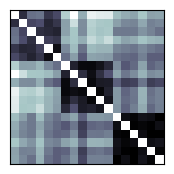

In [419]:
RDM_fmri_expect = rsr.calc_rdm(brain_expect, descriptor='pattern')
# print(RDM_euc_expect)
dist_vectors_fmriexpect = RDM_fmri_expect.get_vectors()
dist_vectors_fmriexpect
RDM_euc_fmri_expect = rsr.RDMs(dist_vectors_fmriexpect)
rdms = rsr.calc_rdm(brain_expect)
rsatoolbox.vis.show_rdm(rdms)

In [ ]:


# for pain, high vs. low cue 
# correlation of average maps between cue map and stimulus map
# per sub/ses/run
# average high
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub = 'sub-0061'
ses = 'ses-01'
run = 'run-06'
runtype = 'pain'
event = 'stimulus'

stim_H_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
stim_M_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
stim_L_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
stim_H_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
stim_M_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
stim_L_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))

# %% Neural RDM

stim_flist = []
[stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]
stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()

runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_runwise = pairwise_distances(runwise_array, metric='euclidean')
plt.imshow(rdm_runwise)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("euclidean-based RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()


# example of a subjectwise RDM

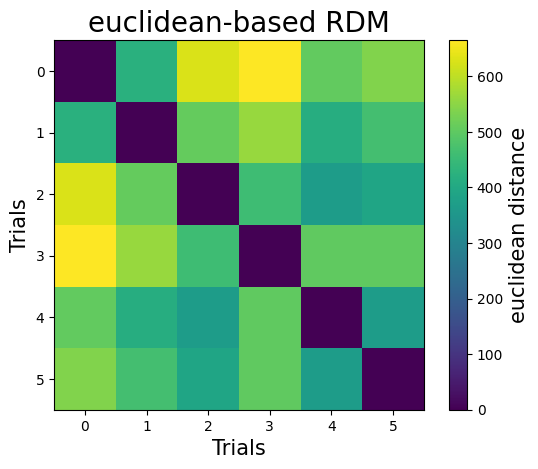

In [154]:


# for pain, high vs. low cue 
# correlation of average maps between cue map and stimulus map
# per sub/ses/run
# average high
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub = 'sub-0061'
ses = 'ses-01'
run = 'run-06'
runtype = 'pain'
event = 'stimulus'
stim_H_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
stim_M_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
stim_L_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
stim_H_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
stim_M_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
stim_L_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))

# %% Neural RDM

stim_flist = []
[stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]
stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()

runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_runwise = pairwise_distances(runwise_array, metric='euclidean')
plt.imshow(rdm_runwise)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("euclidean-based RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()


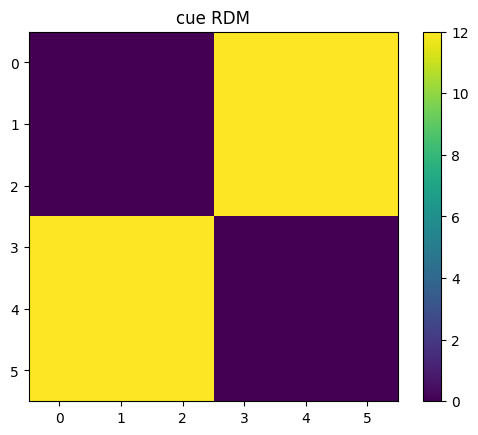

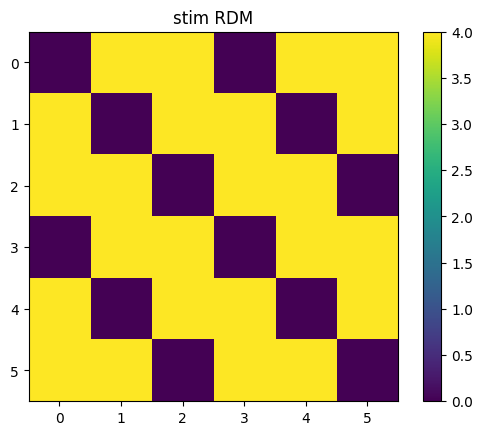

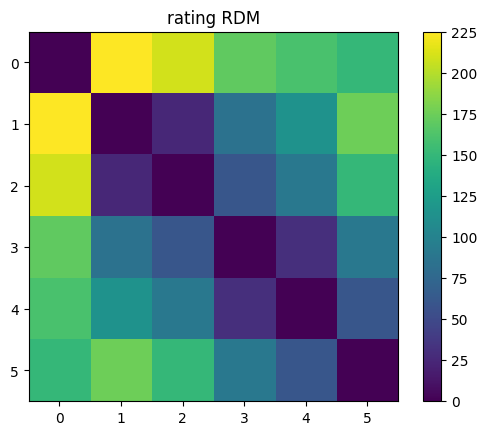

In [4]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
# %% Categorical RDM

cue_category = [[1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1],
                [-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1]]
stim_category = [[1,0,0,1,0,0], 
                 [0,1,0,0,1,0],
                 [0,0,1,0,0,1],
                 [1,0,0,1,0,0], 
                 [0,1,0,0,1,0],
                 [0,0,1,0,0,1]]
# HcHs, HcMs, HcLs, LcHs, LcMs, LcLs
rating_category = [[0,15,20,30,35,45], #90
                   [15,0,-5,-10,-20,-30], #75
                   [20,5,0,-10,-15,-25], #70
                   [30,15,10,0,-5,-15], #60
                   [35,20,15,5,0,-10], #55
                   [45,30,25,15,10,0]] #45
# TODO:
surprise_category = []

rdm_cue = pairwise_distances(cue_category, metric='manhattan')
rdm_stim = pairwise_distances(stim_category, metric='manhattan')
rdm_rating = pairwise_distances(rating_category, metric='manhattan')
plt.imshow(rdm_cue)
plt.colorbar()
plt.title("cue RDM")
plt.show()

plt.imshow(rdm_stim)
plt.colorbar()
plt.title("stim RDM")
plt.show()

plt.imshow(rdm_rating)
plt.colorbar()
plt.title("rating RDM")
plt.show()


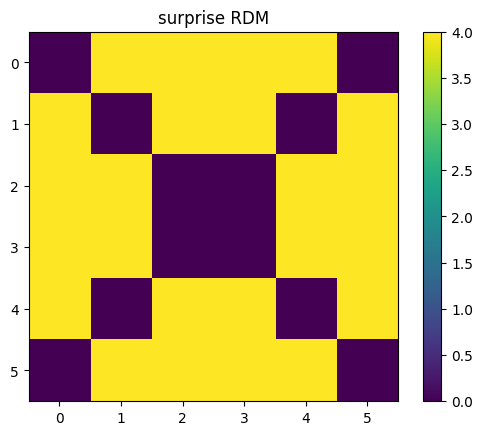

In [6]:
# TODO: barplot. 3 bars. divergence from expectation. 
# HH. LL. vs. HL. LH. 
# RDM: similarity between brain patterns between conditions
# ISC: 
# correlation/ dot product
# similarity cells cue X stim (correelation value, sd of the correlations. betweeen cue and stim. within trial)

# %% Categorical RDM
surprise_category = [[1,0,0,0,0,1],[0,1,0,0,1,0],[0,0,1,1,0,0],
                     [0,0,1,1,0,0],[0,1,0,0,1,0],[1,0,0,0,0,1]]
rdm_surprise = pairwise_distances(surprise_category, metric='manhattan')
plt.imshow(rdm_surprise)
plt.colorbar()
plt.title("surprise RDM")
plt.show()



In [ ]:

from scipy.spatial.distance import squareform
from scipy.stats import kendalltau
rdv_cue = squareform(rdm_cue)
rdv_stim = squareform(rdm_stim)
rdv_runwise = squareform(rdm_runwise.round(5))

rdm_corr, pval = kendalltau(rdv_cue, rdv_runwise)
print("Correlation between RDMs (p-value): %.3f (%.3f)" % (rdm_corr, pval))
print("Shape rdv_R:", rdv_runwise.shape)

#  reweigthing _________________
corr_cue_list =[]
corr_stim_list = []
from scipy.optimize import nnls
A = np.vstack((rdv_cue, rdv_stim))
b = rdv_runwise
sol, rnorm = nnls(A.T, b)
rdv_reweight = sol*A.T

corr_cue, pval_cue = kendalltau(sol[0]*A[0].T, rdv_runwise)
corr_stim, pval_stim = kendalltau(sol[1]*A[1].T, rdv_runwise)

corr_cue_list.extend(corr_cue)
corr_stim_list.extend(corr_stim)
# %%
# for pain, high vs. low cue 
# correlation of average maps between cue map and stimulus map

singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub_list = next(os.walk(singletrial_dir))[1]
sub_folder = sorted([i for i in sub_list if i.startswith('sub-')])
sub = 'sub-0061'
ses = '*'
run = '*'
runtype = 'pain'
event = 'stimulus'
stim_flist = glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-{event}_trial-*.nii.gz'))
stim_flist = sorted(stim_flist)

stacked_stim = image.concat_imgs(sorted(stim_flist))
sub_mean_stim = image.mean_img(stacked_stim)

# cue
cue_flist = glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-cue_trial-*.nii.gz'))
cue_flist = sorted(cue_flist)
stacked_cue = image.concat_imgs(sorted(cue_flist))
sub_mean_cue = image.mean_img(stacked_cue)
# %%
np.corrcoef(sub_mean_cue.get_data().reshape(-1), sub_mean_stim.get_data().reshape(-1))
# %%
# voxel * trial
flist = []
stim_array = image.get_data(stacked_stim)
len_cuestack = stacked_stim.shape[-1]
R_stim = stim_array.reshape(
    np.prod(list(stacked_stim.shape[0:3])), len_cuestack)

cuearray = image.get_data(stacked_cue)
len_cuestack = stacked_cue.shape[-1]
R_cue = cuearray.reshape(
    np.prod(list(stacked_cue.shape[0:3])), len_cuestack)

R_stimcue = np.hstack((R_stim, R_cue))
flist.extend(stim_flist)
flist.extend(cue_flist)
# %%
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_stimcue = pairwise_distances(R_stimcue.T, metric='euclidean')
plt.imshow(rdm_stimcue)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("euclidean-based RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()
# %%








# %% Ver 2: stack and order
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub = 'sub-0061'
ses = '*'
run = '*'
runtype = 'pain'
event = 'stimulus'
stim_H_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
stim_M_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
stim_L_cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
stim_H_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
stim_M_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
stim_L_cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))

stim_flist = []
[stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]
stacked_stim = image.concat_imgs(stim_flist)
sub_mean_stim = image.mean_img(stacked_stim)

# cue
cue_H = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-cue_trial-*_cuetype-high.nii.gz')))
cue_L = sorted(glob.glob(os.path.join(
    singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-cue_trial-*_cuetype-low.nii.gz')))

cue_flist = []
[cue_flist.extend(l) for l in (cue_H, cue_L)]
stacked_cue = image.concat_imgs(cue_flist)
sub_mean_cue = image.mean_img(stacked_cue)

np.corrcoef(sub_mean_cue.get_data().reshape(-1), sub_mean_stim.get_data().reshape(-1))
# %%
# voxel * trial
flist = []
stim_array = image.get_data(stacked_stim)
len_cuestack = stacked_cue.shape[-1]
R_stim = stim_array.reshape(
    np.prod(list(stacked_cue.shape[0:3])), len_cuestack)

cuearray = image.get_data(stacked_cue)
len_cuestack = stacked_cue.shape[-1]
R_cue = cuearray.reshape(
    np.prod(list(stacked_cue.shape[0:3])), len_cuestack)

R_stimcue = np.hstack((R_stim, R_cue))
flist.extend(stim_flist)
flist.extend(cue_flist)
# %%
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_stimcue = pairwise_distances(R_stimcue.T, metric='euclidean')
plt.imshow(rdm_stimcue)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("euclidean-based RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()
# %%


















# %% Version 3
# condition wise
RDM_stim = np.array([])
track_flist = []
for cue, stim in [('high', 'high'),
                    ('high', 'med'),
                    ('high', 'low'),
                    ('low', 'high'),
                    ('low', 'med'),
                    ('low', 'low')]:
    for sub in sub_folder:
        stim_flist = []
        ses = '*'
        run = '*'
        runtype = 'pain'
        stim_flist = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-{cue}_stimintensity-{stim}.nii.gz')))
        if stim_flist:
            track_flist.extend(stim_flist)
            stacked_stim = image.concat_imgs(stim_flist)
            sub_mean_stim = image.mean_img(stacked_stim)
            stim_array = image.get_data(sub_mean_stim)
            RDM_stim = np.vstack([RDM_stim, stim_array.ravel()]) if RDM_stim.size else stim_array.ravel()
        # RDM_stim = np.concatenate((RDM_stim, stim_array.ravel()), axis = 0)

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_stimcue = pairwise_distances(RDM_stim, metric='euclidean')
plt.imshow(rdm_stimcue)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("cue-wise RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()


# %% Version 3-2
# condition wise - intensity
RDM_stim = np.array([])
track_flist = []
for cue, stim in [('high', 'high'),
                    ('low', 'high'),
                    ('high', 'med'),
                    ('low', 'med'),
                    ('high', 'low'),
                    ('low', 'low')]:
    for sub in sub_folder:
        stim_flist = []
        ses = '*'
        run = '*'
        runtype = 'pain'
        stim_flist = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-{cue}_stimintensity-{stim}.nii.gz')))
        if stim_flist:
            track_flist.extend(stim_flist)
            stacked_stim = image.concat_imgs(stim_flist)
            sub_mean_stim = image.mean_img(stacked_stim)
            stim_array = image.get_data(sub_mean_stim)
            RDM_stim = np.vstack([RDM_stim, stim_array.ravel()]) if RDM_stim.size else stim_array.ravel()
        # RDM_stim = np.concatenate((RDM_stim, stim_array.ravel()), axis = 0)

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_stimcue = pairwise_distances(RDM_stim, metric='euclidean')
plt.imshow(rdm_stimcue)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("intensity wise RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()


# %% Version 4
# subject wise
RDM_stim = np.array([])
track_flist = []

for sub in sub_folder:
    for cue, stim in [('high', 'high'),
                ('high', 'med'),
                ('high', 'low'),
                ('low', 'high'),
                ('low', 'med'),
                ('low', 'low')]:

        stim_flist = []
        ses = '*'
        run = '*'
        runtype = 'pain'
        stim_flist = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-{cue}_stimintensity-{stim}.nii.gz')))
        if stim_flist:
            track_flist.extend(stim_flist)
            stacked_stim = image.concat_imgs(stim_flist)
            sub_mean_stim = image.mean_img(stacked_stim)
            stim_array = image.get_data(sub_mean_stim)
            RDM_stim = np.vstack([RDM_stim, stim_array.ravel()]) if RDM_stim.size else stim_array.ravel()
        # RDM_stim = np.concatenate((RDM_stim, stim_array.ravel()), axis = 0)

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rdm_stimcue = pairwise_distances(RDM_stim, metric='euclidean')
plt.imshow(rdm_stimcue)
plt.xlabel("Trials", fontsize=15)
plt.ylabel("Trials", fontsize=15)
plt.title("subjectwise RDM", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('euclidean distance', fontsize=15)
plt.show()


